In [1]:
"""
FINITE ELEMENT
Two-Dimensional Triangular Element.

Created by:
Karina Chinas Fuentes

Date:
October 30, 2019

REFERENCE:
This code was created by considering the The Finite Element Method:
    Basic Concepts and Applications with MATLAB ® , MAPLE, and COMSOL
    T H I R D     E D I T I O N
    By: W. J. Minkowycz; and E. M. Sparrow.
"""

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
sp.init_printing(use_unicode=True)

# THE FINITE ELEMENT METHOD
## TWO DIMENSIONAL TRIANGULAR ELEMENT 

### HEAT TRANSFER

This code is an example of how to solve for the temperature of a rectangular plate that looses heat on its right side by using triangular elements, consisting of three vertex nodes. In this case, we are solving for a mesh containing $n_e$ number of triangular elementes that covers a rectangular plate, considering that it is loosing heat at its right side and the others sides remain isolated.

In [2]:
ne = 10        #Number of Elements

if ne%2 != 0:  # The idea is to hava only an even numer of elements.
    ne = ne +1

nodes = ne + 2

lx_T  = 1    # m
ly_T  = 1    # m
k     = 1    # W/m*C
q     = -50  # W/m^2
Q     = 500  # W/m^3 

x = np.linspace(0, lx_T, int(ne/2)+1)

nx    = len(x) # Number of nodes in x
ny    = 2      # Number of nodes in y

y = np.linspace(0,ly_T,ny)

lx_e  = x[1]
A_e   = (lx_e*ly_T)/2

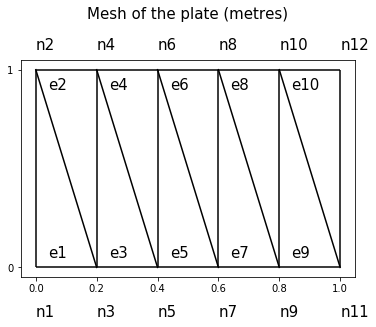

In [3]:
#FIGURE OF THE MESH 

#plt.figure(figsize=(10,10))

# Delimitation of the plate and vertical lines
for i in range(int(ne/2)+1):
    plt.text(i*lx_e,ly_T + 0.1*ly_T,f"n{2*i+2}", fontsize = 15)
    plt.text(i*lx_e,0 - 0.25*ly_T,f"n{2*i+1}", fontsize = 15)
    plt.vlines(x = i*lx_e, ymin = 0, ymax = ly_T )
plt.hlines(ly_T, xmin = 0, xmax=x[-1])
plt.hlines(0, xmin = 0, xmax=x[-1])

# Delimitation of the elements
for i in range(int(ne/2)):
    plt.plot([x[i+1],x[i]],[y[0],y[-1]], color = 'k')
for i in range(int(ne/2)):
    plt.text((i+0.2)*lx_e,0.9*ly_T,f"e{2*i+2}", fontsize = 15)
    plt.text((i+0.2)*lx_e,0.05*ly_T,f"e{2*i+1}", fontsize = 15)
    
plt.xticks(x)
plt.yticks(y)

plt.title("Mesh of the plate (metres)\n\n", fontsize = 15)

plt.show()


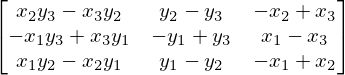

In [4]:
x1,x2,x3 = sp.symbols('x_1,x_2,x_3')
y1,y2,y3 = sp.symbols('y_1,y_2,y_3')
z1,z2,z3 = sp.symbols('z_1,z_2,z_3')
x,y,z    = sp.symbols('x,y,z')

X = sp.Matrix([x1,x2,x3])
Y = sp.Matrix([y1,y2,y3])
Z = sp.Matrix([z1,z2,z3])


XY = X.cross(Y)
r1 = [1,2,0]
r2 = [2,0,1]

R = [X,Y,Z]
C = sp.zeros(3)

for i in range(3):
    for j in range(3):
        if j == 0:
            C[i,j] = XY[i]
        elif j == 1:
            C[i,j] = Y[r1[i]] - Y[r2[i]]
        elif j == 2:
            C[i,j] = X[r2[i]] - X[r1[i]]


ai = sp.zeros(3).col(0)
bi = sp.zeros(3).col(0)
ci = sp.zeros(3).col(0)

for i in range(3): 
    for j in range(3):
        if   i == 0:
            ai[j] = C[j,i]
        elif i == 1:
            bi[j] = C[j,i]
        elif i == 2:
            ci[j] = C[j,i]
            

K = sp.zeros(3)
for i in range(3):
    for j in range(3):
        K[i,j] = bi[i]*bi[j] + ci[i]*ci[j]
K = (k/(4*A_e))*K
C

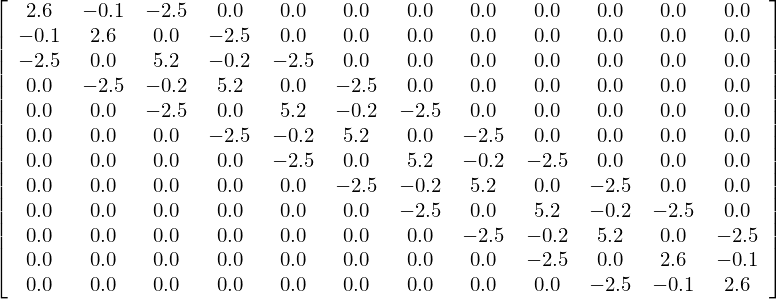

In [5]:
K_par   = K.subs({x1:0, x2:lx_e,x3:lx_e, y1:ly_T, y2:0, y3:ly_T})

K_impar = K.subs({x1:0, x2:0, x3:lx_e, y1:0 , y2: ly_T, y3:0})

KT = [K_par, K_impar]
M = np.zeros((nodes,nodes))

for k in range(ne):
    for i in range(3):
        for j in range(3):
            M[k+i,k+j] = M[k+i,k+j] + KT[(k+1)%2][i,j]
sp.Matrix(M)

In [6]:
# Force Vectors: conduction.
F_Q = sp.ones(3).col(0)
F_Q = (Q*A_e/3)*F_Q

F_12 = sp.ones(3).col(0)
F_12[-1] = 0
F_12 = (q*ly_T/2)*F_12 

F_e1 =  F_12 + F_Q
F = sp.zeros(nodes).col(0)
F[0] = F_e1

for k in range(1,ne):
    for i in range(3):
        F[i+k] = F[i+k] + F_Q[i]

In [7]:
# Dirichlet boundary condition
M[-1], M[-2] = np.zeros(nodes), np.zeros(nodes)
M[-1,-1], M[-2,-2] = 1,1
F[-1], F[-2] = 0,0

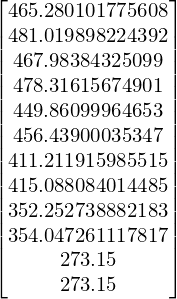

In [8]:
#Solución 
Temp = np.linalg.inv(M)*F + 273.15*sp.ones(nodes).col(0)
Temp # en Kelvin

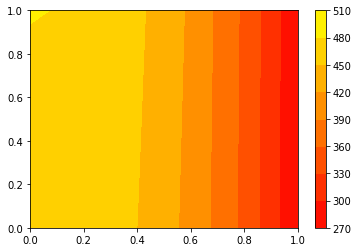

In [9]:
# Heat Map

x = np.linspace(0,lx_T,nx)
y = np.linspace(0,ly_T,ny)

MT = np.zeros((ny,nx))
par = [i for i in range(0,nodes,2)]
impar = [i for i in range(1,nodes,2)]

for i in range(len(par)):
    MT[0,i] = Temp[par[i]]
    MT[1,i] = Temp[impar[i]]
    
plt.contourf(x, y, MT, cmap=plt.cm.autumn)
plt.colorbar()